# Problem

**10×10 Gridworld**

**Layout (row-major indices)**

Legend: **S** start, **G** goal (terminal), **P** pit (terminal), **#** wall, **.** empty

```
r\c  0 1 2 3 4 5 6 7 8 9
0    S . . . # . . . . .
1    . # . . # . . # P .
2    . # # . . . . # . .
3    . . P . # . . # . .
4    # . # # # # # # . #
5    . . . . # . . P . .
6    . P # . # . # . . .
7    . . # . . P # . . .
8    . . # . # . # # . .
9    . . . . # . . . . G
```

**State space**

$$
\mathcal{X}={0,1,\dots,99},\quad x=10r+c
$$

* **Goal (absorbing):** $x_G=99$
* **Pits (absorbing):**
  $
  \mathcal{X}_{\text{pit}}={18,32,57,61,75,88}
  $
* **Walls (impassable):**
  $
  \mathcal{X}_{\text{wall}}={4,11,14,17,21,22,27,34,37,40,42,43,44,45,46,47,49,54,62,64,66,72,76,82,84,86,87,94}
  $

Terminal set:
$
\mathcal{T}={99}\cup \mathcal{X}_{\text{pit}}
$

**Action space**

$$
\mathcal{A}={0,1,2,3}
$$
where (0=) Up, (1=) Down, (2=) Left, (3=) Right.

**Transition dynamics (deterministic)**

Let $x\mapsto(r,c)$ by $r=\lfloor x/10\rfloor,\ c=x\bmod 10$.

* If $x\in\mathcal{T}$, then $\text{next\_state}(x,a)=x$ $absorbing$.
* Otherwise, compute the intended neighbor $(r',c')$ from action $a$.
* If $(r',c')$ is outside the grid, **stay**.
* Let $x'=10r'+c'$. If $x'\in\mathcal{X}_{\text{wall}}$, **stay**.

Transition matrix shape:
$$
P\in\mathbb{R}^{(|\mathcal{X}||\mathcal{A}|)\times|\mathcal{X}|}=\mathbb{R}^{400\times 100},
$$
with
$$
P[(x,a),x']=1 \iff x'=\text{next\_state}(x,a)
$$

**Reward model (standard step cost + terminal outcomes)**

Reward based on the **next state**:
$$
r(x,a)=
\begin{cases}
+1 & \text{if } \text{next\_state}(x,a)=99,\
-5 & \text{if } \text{next\_state}(x,a)\in \mathcal{X}_{\text{pit}},\
-0.1 & \text{otherwise.}
\end{cases}
$$

**Initial state**

$$
x_0=0.
$$

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import random
import torch
import pandas as pd
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans

# This starts from the current working directory
# and goes up until it finds the 'fogas_torch' folder or '.git'
def find_root(current_path, marker="fogas_torch"):
    current_path = Path(current_path).resolve()
    for parent in [current_path] + list(current_path.parents):
        if (parent / marker).exists():
            return parent
    return current_path

PROJECT_ROOT = find_root(Path.cwd())
print(f"Project root found at: {PROJECT_ROOT}")

# Add project root to sys.path so we can import local packages
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
# Now define the dataset path
DATASET_PATH = PROJECT_ROOT / "datasets" / "10grid_RBF.csv"
print(f"Loading dataset from: {DATASET_PATH}")

from fogas_torch import PolicySolver, EnvDataCollector
from fogas_torch.algorithm import (
    FOGASSolverVectorized,
    FOGASOracleSolverVectorized,
    FOGASHyperOptimizer,
    FOGASEvaluator,
    FOGASDataset,
)
from fogas.dataset_collection.dataset_analyzer import DatasetAnalyzer
from fogas_torch.fqi.fqi_solver import FQISolver
from fogas_torch.fqi.fqi_evaluator import FQIEvaluator

seed = 42
np.random.seed(seed) # Add this
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Project root found at: /shared/home/mauro.diaz/work/FOGAS
Loading dataset from: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_RBF.csv
Using device: cuda


# RBF Features

## With goal - pit condition feature

In [2]:
# ===== 10x10 Four-Rooms Grid Configuration =====
states  = torch.arange(100, dtype=torch.int64)
actions = torch.arange(4, dtype=torch.int64)
N, A = 100, 4
gamma = 0.9
goal = 99
pits = {18, 32, 57, 61, 75}
walls = {
    4, 11, 14, 17, 21, 22, 27, 34, 37,
    40, 42, 43, 44, 45, 46, 47, 49,
    54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94
}

from sklearn.cluster import KMeans

# -----------------------------------------------------------------------
# Shared Helpers
# -----------------------------------------------------------------------
def get_norm_coords(s):
    r, c = divmod(int(s), 10)
    return torch.tensor([r / 9.0, c / 9.0], dtype=torch.float64)

def calculate_local_sigma(centers, k=2):
    """
    Computes sigma based on the k-nearest neighbors.
    This is much better for FOGAS in environments with walls.
    """
    dist_matrix = torch.cdist(centers, centers, p=2)
    # topk(k+1) because the closest point is always the point itself (dist=0)
    topk_dists, _ = torch.topk(dist_matrix, k + 1, largest=False, dim=1)
    # Use the distance to the 1st nearest neighbor (index 1 skips self at 0)
    nearest_neighbor_dists = topk_dists[:, 1]
    return torch.mean(nearest_neighbor_dists)

def calculate_median_sigma(centers):
    """Median Trick: sigma = median of all pairwise distances."""
    dist_matrix = torch.cdist(centers, centers, p=2)
    indices = torch.triu_indices(len(centers), len(centers), offset=1)
    pairwise_distances = dist_matrix[indices[0], indices[1]]
    return torch.median(pairwise_distances)

# -----------------------------------------------------------------------
# MDP 1 — 30 KMeans centers + bias + indicators (is_pit, is_goal)
# -----------------------------------------------------------------------
def get_kmeans_centers(num_centers=25):
    """K-Means on all non-wall states (normalized coords)."""
    valid_coords = []
    for s in range(100):
        if s not in walls:
            r, c = divmod(s, 10)
            valid_coords.append([r / 9.0, c / 9.0])
    kmeans = KMeans(n_clusters=num_centers, n_init=10, random_state=42).fit(valid_coords)
    return torch.tensor(kmeans.cluster_centers_, dtype=torch.float64)

num_rbf_centers = 30
centers   = get_kmeans_centers(num_centers=num_rbf_centers)
rbf_sigma = calculate_local_sigma(centers, k=2)

def phi_state(x):
    coords  = get_norm_coords(x)
    dist_sq = torch.sum((coords - centers)**2, dim=1)
    rbf     = torch.exp(-dist_sq / (2 * rbf_sigma**2))
    is_pit  = 1.0 if int(x) in pits else 0.0
    is_goal = 1.0 if int(x) == goal else 0.0
    indicators = torch.tensor([is_pit, is_goal], dtype=torch.float64)
    return torch.cat([rbf, torch.ones(1, dtype=torch.float64), indicators])

def phi(x, a):
    """Coupled Feature Map: phi(x, a) = e_a ⊗ phi_state(x)."""
    s_feat = phi_state(x)
    e_a    = torch.zeros(A, dtype=torch.float64)
    e_a[int(a)] = 1.0
    return torch.kron(e_a, s_feat)

d = int(phi(states[0], actions[0]).shape[0])

# -----------------------------------------------------------------------
# Reward function and Transition Matrix (shared by both MDPs)
# -----------------------------------------------------------------------
def reward_fn(x, a):
    x_int = int(x)
    if x_int == goal:   return  1.0
    if x_int in pits:   return -5.0
    return -0.1

P = torch.zeros((N * A, N), dtype=torch.float64)
for x in range(N):
    for a in range(A):
        if x in pits or x == goal:
            P[x * A + a, x] = 1.0
            continue
        r, c = divmod(x, 10)
        if   a == 0: r_next, c_next = max(0, r-1), c
        elif a == 1: r_next, c_next = min(9, r+1), c
        elif a == 2: r_next, c_next = r, max(0, c-1)
        elif a == 3: r_next, c_next = r, min(9, c+1)
        next_state = r_next * 10 + c_next
        if next_state in walls:
            next_state = x
        P[x * A + a, next_state] = 1.0

# ---------- Create MDP 1 ----------
mdp = PolicySolver(
    states=states, actions=actions, phi=phi,
    reward_fn=reward_fn, gamma=gamma, x0=0, P=P,
)

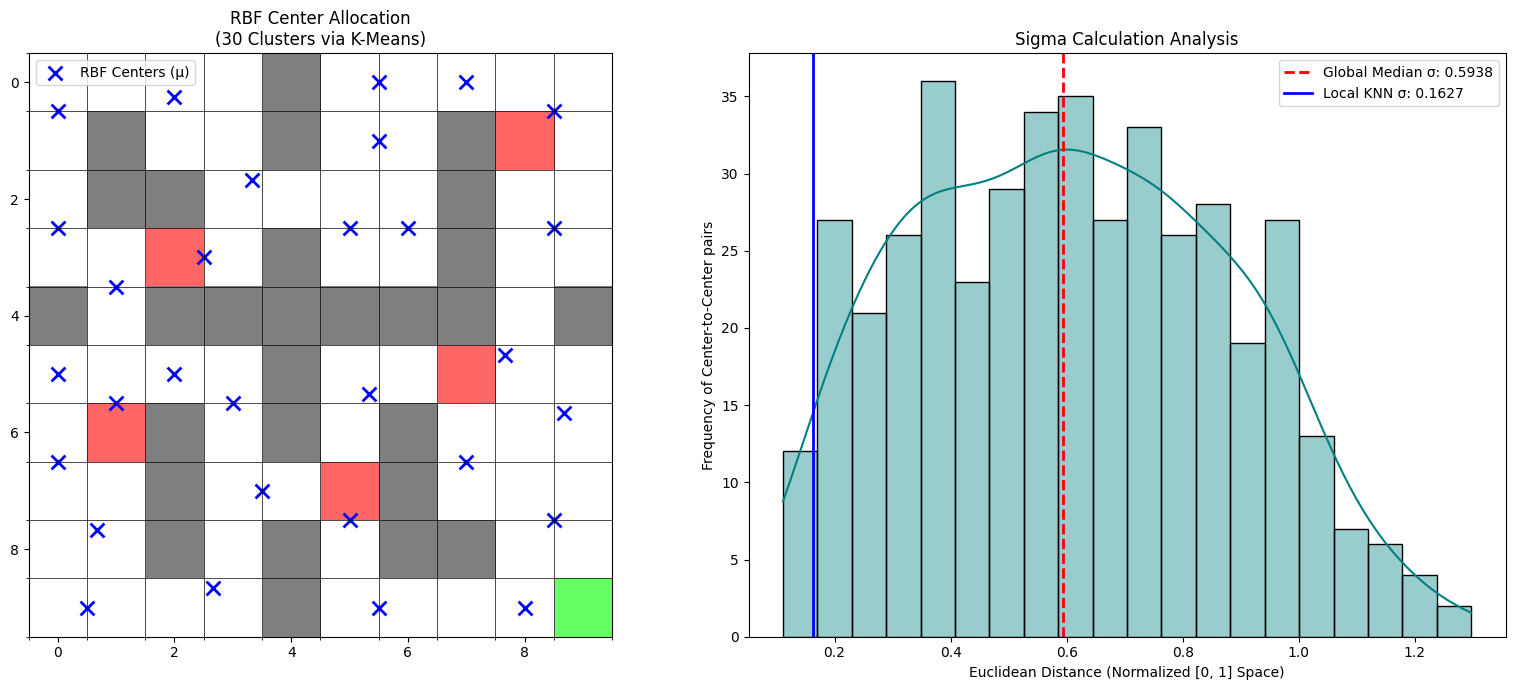

Metric                    | Value     
----------------------------------------
Global Median Sigma       | 0.593821
Local KNN Sigma (k=2)     | 0.162732
Difference (%)            | 72.60%
----------------------------------------
RATIONALE:
1. Global Median: Better for 'Smoothing'—covers the whole range of distances.
2. Local KNN: Better for 'Precision'—ensures centers only overlap with their
   immediate neighbors, preventing blurry feature activations across rooms.


In [15]:
def visualize_rbf_analysis(centers, walls, pits, goal):
    # 1. Compute both Sigmas
    sigma_median = calculate_median_sigma(centers).item()
    sigma_local = calculate_local_sigma(centers, k=2).item()
    
    # --- PLOT 1: Spatial Grid Visualization ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    grid_display = np.ones((10, 10, 3)) 
    for s in range(100):
        r, c = divmod(s, 10)
        if s in walls: grid_display[r, c] = [0.5, 0.5, 0.5]
        elif s in pits: grid_display[r, c] = [1.0, 0.4, 0.4]
        elif s == goal: grid_display[r, c] = [0.4, 1.0, 0.4]

    ax1.imshow(grid_display, origin='upper')
    centers_np = centers.numpy() * 9.0
    ax1.scatter(centers_np[:, 1], centers_np[:, 0], 
                color='blue', marker='x', s=100, label='RBF Centers (μ)', linewidths=2)
    
    ax1.set_xticks(np.arange(-0.5, 10, 1), minor=True); ax1.set_yticks(np.arange(-0.5, 10, 1), minor=True)
    ax1.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax1.set_title(f"RBF Center Allocation\n({len(centers)} Clusters via K-Means)")
    ax1.legend()

    # --- PLOT 2: Sigma Distribution Analysis ---
    dist_matrix = torch.cdist(centers, centers, p=2)
    indices = torch.triu_indices(len(centers), len(centers), offset=1)
    pairwise_distances = dist_matrix[indices[0], indices[1]].numpy()
    
    sns.histplot(pairwise_distances, kde=True, color='teal', bins=20, ax=ax2, alpha=0.4)
    ax2.axvline(sigma_median, color='red', linestyle='--', linewidth=2, 
                label=f'Global Median σ: {sigma_median:.4f}')
    ax2.axvline(sigma_local, color='blue', linestyle='-', linewidth=2, 
                label=f'Local KNN σ: {sigma_local:.4f}')
    
    ax2.set_title("Sigma Calculation Analysis")
    ax2.set_xlabel("Euclidean Distance (Normalized [0, 1] Space)")
    ax2.set_ylabel("Frequency of Center-to-Center pairs")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

    # --- Print Stats Table ---
    print(f"{'Metric':<25} | {'Value':<10}")
    print("-" * 40)
    print(f"{'Global Median Sigma':<25} | {sigma_median:.6f}")
    print(f"{'Local KNN Sigma (k=2)':<25} | {sigma_local:.6f}")
    print(f"{'Difference (%)':<25} | {abs(sigma_median-sigma_local)/sigma_median*100:.2f}%")
    print("-" * 40)
    print(f"RATIONALE:")
    print(f"1. Global Median: Better for 'Smoothing'—covers the whole range of distances.")
    print(f"2. Local KNN: Better for 'Precision'—ensures centers only overlap with their")
    print(f"   immediate neighbors, preventing blurry feature activations across rooms.")

# Run the visualizer
visualize_rbf_analysis(centers, walls, pits, goal)

### Dataset creation

In [46]:
# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_rbf",
    reset_probs={'custom': 1.0},
    max_steps=50,
    seed=seed
)

# Create an epsilon-greedy pi_star (30% optimal, 70% random)
epsilon_policy = (mdp.pi_star, 0.3)

collector.collect_mixed_dataset_terminal_aware(
    policies=[epsilon_policy, "random"],  
    proportions=[0.8, 0.2],
    n_steps=8000,
    episode_based=True,                   
    save_path=str(DATASET_PATH),
    verbose=True,
    extra_steps=3  
)


  MIXED TERMINAL-AWARE DATASET COLLECTION SUMMARY (TORCH)
Total transitions: 8000
Total episodes: 221
Extra steps: 3

Policy Distribution:
  Policy 0:  5995 steps (74.9%) | Target: 80.0% | Episodes: 176
  Policy 1:  2005 steps (25.1%) | Target: 20.0% | Episodes: 46

✅ Mixed terminal-aware dataset saved to: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_RBF.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,0,0,-0.1,0,0
1,0,1,0,3,-0.1,1,0
2,0,2,1,3,-0.1,2,0
3,0,3,2,1,-0.1,12,0
4,0,4,12,3,-0.1,13,0
...,...,...,...,...,...,...,...
7995,221,9,23,3,-0.1,24,0
7996,221,10,24,3,-0.1,25,0
7997,221,11,25,2,-0.1,24,0
7998,221,12,24,3,-0.1,25,0


### Solving it

[FOGASSolverVectorized] omega estimated via regression (beta_omega=1.02e-06, n=8000)

     REWARD APPROXIMATION ANALYSIS
Metric                                Value
────────────────────────────────────────────
Max |error|                        0.023683
Mean |error|                       0.002008
RMSE                               0.004334
R² (explained variance)            0.999985

--------------------------------------------------
State  Action         r_true      r_hat      error
──────────────────────────────────────────────────
0            ↑ Up          -0.1000    -0.0999     0.0001
0            ↓ Down        -0.1000    -0.1000     0.0000
0            ← Left        -0.1000    -0.0999     0.0001
0            → Right       -0.1000    -0.1000     0.0000
1            ↑ Up          -0.1000    -0.1001    -0.0001
1            ↓ Down        -0.1000    -0.1000    -0.0000
1            ← Left        -0.1000    -0.1001    -0.0001
1            → Right       -0.1000    -0.1000    -0.0000
2   

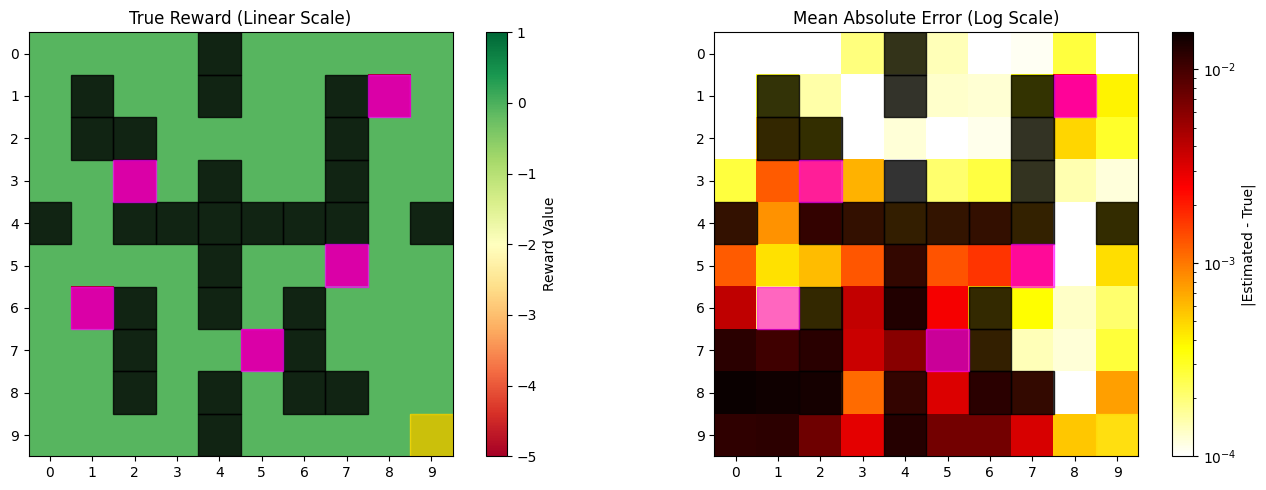

In [54]:
solver_e = FOGASSolverVectorized(
    mdp=mdp,
    csv_path=str(DATASET_PATH),
    device=device,
    seed=seed)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)


evaluator_e.analyze_reward_approximation(
    walls=walls, 
    pits=pits, 
    goal=goal
)

In [48]:
# Run solver with best alpha and fixed rho, eta
solver_e.run(alpha=0.001 / 2, eta=0.0002, rho=0.05, tqdm_print=True, T=13000)
evaluator_e.print_policy()

FOGAS:   4%|█████▌                                                                                                                                 | 537/13000 [00:00<00:07, 1734.42it/s]

FOGAS: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13000/13000 [00:07<00:00, 1694.43it/s]

  State 0: π(a=0|s=0) = 0.17  π(a=1|s=0) = 0.19  π(a=2|s=0) = 0.15  π(a=3|s=0) = 0.48  --> best action: 3
  State 1: π(a=0|s=1) = 0.12  π(a=1|s=1) = 0.09  π(a=2|s=1) = 0.06  π(a=3|s=1) = 0.72  --> best action: 3
  State 2: π(a=0|s=2) = 0.18  π(a=1|s=2) = 0.28  π(a=2|s=2) = 0.08  π(a=3|s=2) = 0.46  --> best action: 3
  State 3: π(a=0|s=3) = 0.18  π(a=1|s=3) = 0.61  π(a=2|s=3) = 0.06  π(a=3|s=3) = 0.15  --> best action: 1
  State 4: π(a=0|s=4) = 0.18  π(a=1|s=4) = 0.46  π(a=2|s=4) = 0.04  π(a=3|s=4) = 0.32  --> best action: 1
  State 5: π(a=0|s=5) = 0.09  π(a=1|s=5) = 0.05  π(a=2|s=5) = 0.01  π(a=3|s=5) = 0.85  --> best action: 3
  State 6: π(a=0|s=6) = 0.08  π(a=1|s=6) = 0.01  π(a=2|s=6) = 0.03  π(a=3|s=6) = 0.88  --> best action: 3
  State 7: π(a=0|s=7) = 0.14  π(a=1|s=7) = 0.05  π(a=2|s=7) = 0.10  π(a=3|s=7) = 0.70  --> best action: 3
  State 8: π(a=0|s=8) = 0.12  π(a=1|s=8) = 0.42  π(a=2|s=8) = 0.02  π(a=3|s=8) = 0.44  --> best action: 3
  State 9: π(a=0|s=9) = 0.04  π(a=1|s=9) = 0.9

In [49]:
evaluator_e.print_optimal_path(goal_state=99)


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Goal State: 99
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 3       │ Reward:  -0.100 │ → 3
  Step   3 │ State: 3        │ Action: 1       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 3       │ Reward:  -0.100 │ → 16
  Step   9 │ State: 16       │ Action: 0       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7    

## Only RBF features

In [33]:
# -----------------------------------------------------------------------
# MDP 2 — Anchored RBFs: KMeans free centers + explicit goal/pit centers
#          Free centers  → global KNN sigma
#          Anchor centers → small local sigma  (sharply localized)
#          No indicator features — only pure RBFs
# -----------------------------------------------------------------------
def get_anchored_centers(num_free_centers=35, anchor_states=None):
    """
    Returns:
        all_centers  : (num_free + num_anchors, 2) tensor
        n_free       : number of free K-Means centers
        n_anchors    : number of anchor centers
        
    Free centers   → K-Means on states that are NOT walls and NOT anchors.
    Anchor centers → placed exactly at the target states (goal, pits).
    """
    anchor_states = set(anchor_states or [])

    # Free center pool: exclude walls AND anchors so K-Means doesn't
    # accidentally absorb the anchor positions into generic centers
    valid_coords = []
    for s in range(100):
        if s not in anchor_states: #and s not in walls:
            r, c = divmod(s, 10)
            valid_coords.append([r / 9.0, c / 9.0])

    kmeans       = KMeans(n_clusters=num_free_centers, n_init=10, random_state=42).fit(valid_coords)
    free_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float64)

    # Anchor centers placed exactly at the special states (sorted for reproducibility)
    anchor_coords = [[divmod(s, 10)[0] / 9.0, divmod(s, 10)[1] / 9.0]
                     for s in sorted(anchor_states)]
    anchor_centers = torch.tensor(anchor_coords, dtype=torch.float64)

    all_centers = torch.cat([free_centers, anchor_centers], dim=0)
    return all_centers, len(free_centers), len(anchor_centers)


# Hyperparameters for MDP 2
num_free_centers2 = 35                        # free K-Means centers (non-wall, non-anchor)
anchor_states2    = {goal} | pits             # goal + all 5 pits
sigma_scale       = 0.25                      # anchor sigma = global_sigma * scale
                                              # → activation at nearest neighbor ≈ exp(-1/8σ)
                                              # small enough to avoid bleeding

centers2, n_free2, n_anchors2 = get_anchored_centers(
    num_free_centers=num_free_centers2,
    anchor_states=anchor_states2,
)

# Sigma for free centers: KNN on the full center set (includes anchors → conservative)
sigma_global2 = calculate_local_sigma(centers2, k=2)

# Sigma for anchor centers: much smaller → sharply localized basis functions
sigma_anchor2 = sigma_global2 * sigma_scale

# Per-center sigma vector: (K,)
sigmas2 = torch.full((len(centers2),), sigma_global2, dtype=torch.float64)
sigmas2[n_free2:] = sigma_anchor2            # override for the last n_anchors entries

print(f"MDP2: {n_free2} free centers + {n_anchors2} anchor centers = {len(centers2)} total")
print(f"  sigma_global = {sigma_global2:.4f}")
print(f"  sigma_anchor = {sigma_anchor2:.4f}  (scale={sigma_scale})")
print(f"  d2 = A * (K + bias) = {A} * ({len(centers2)} + 1) = {A * (len(centers2) + 1)}")


def phi_state2(x):
    """
    Pure RBF features with per-center sigma.
    Free centers  use sigma_global2 → smooth spatial generalization.
    Anchor centers use sigma_anchor2 → sharp, localized reward isolation.
    No indicator features needed.
    """
    coords  = get_norm_coords(x)
    dist_sq = torch.sum((coords - centers2)**2, dim=1)      # (K,)
    rbf     = torch.exp(-dist_sq / (2 * sigmas2**2))        # (K,) — per-center sigma
    return torch.cat([rbf, torch.ones(1, dtype=torch.float64)])   # +bias

def phi2(x, a):
    """Coupled Feature Map: phi2(x, a) = e_a ⊗ phi_state2(x)."""
    s_feat      = phi_state2(x)
    e_a         = torch.zeros(A, dtype=torch.float64)
    e_a[int(a)] = 1.0
    return torch.kron(e_a, s_feat)

d2 = int(phi2(states[0], actions[0]).shape[0])

# ---------- Create MDP 2 ----------
mdp2 = PolicySolver(
    states=states, actions=actions, phi=phi2,
    reward_fn=reward_fn, gamma=gamma, x0=0, P=P,
)

MDP2: 35 free centers + 6 anchor centers = 41 total
  sigma_global = 0.1377
  sigma_anchor = 0.0344  (scale=0.25)
  d2 = A * (K + bias) = 4 * (41 + 1) = 168


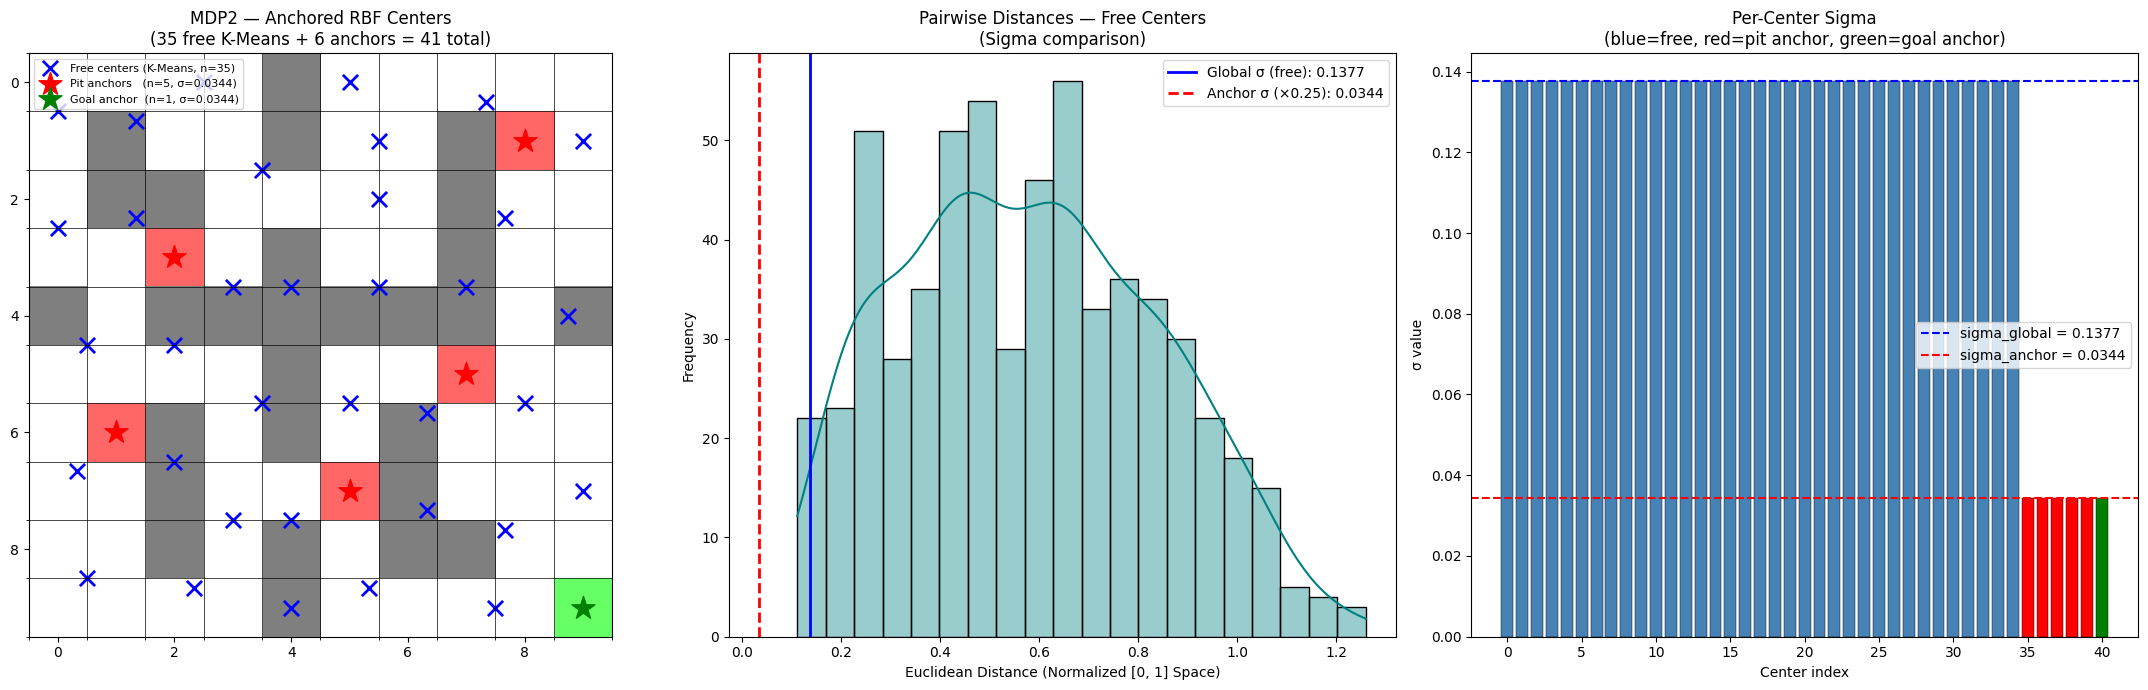

Metric                              | Value       
----------------------------------------------------
Total centers                       | 41
  Free (K-Means)                    | 35
  Anchors (goal + pits)             | 6
Global sigma (free centers)         | 0.137671
Anchor sigma                        | 0.034418
Sigma scale (anchor/global)         | 0.25×
Feature dim d2                      | 168
----------------------------------------------------
RATIONALE (MDP2 anchored design):
  Free centers  → KNN sigma → smooth spatial generalization across rooms
  Anchor centers → small sigma → sharp, isolated activation at goal/pits
  → omega regression can assign large weights to anchors without bleeding


In [34]:
def visualize_rbf_analysis2(centers2, n_free, sigmas2, sigma_global, sigma_anchor,
                              walls, pits, goal):
    """
    Visualization for the anchored RBF setup of mdp2.
    - Free centers (K-Means)  → blue  crosses, sigma_global
    - Anchor centers (goal/pits) → star markers, sigma_anchor (small)
    """
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))

    # ------------------------------------------------------------------ #
    # PLOT 1: Spatial Grid — free vs anchor centers
    # ------------------------------------------------------------------ #
    ax1 = axes[0]
    grid_display = np.ones((10, 10, 3))
    for s in range(100):
        r, c = divmod(s, 10)
        if s in walls:     grid_display[r, c] = [0.5, 0.5, 0.5]
        elif s in pits:    grid_display[r, c] = [1.0, 0.4, 0.4]
        elif s == goal:    grid_display[r, c] = [0.4, 1.0, 0.4]

    ax1.imshow(grid_display, origin='upper')

    centers2_np = centers2.numpy() * 9.0

    # Free centers
    ax1.scatter(centers2_np[:n_free, 1], centers2_np[:n_free, 0],
                color='blue', marker='x', s=120, linewidths=2,
                label=f'Free centers (K-Means, n={n_free})')

    # Anchor centers — split goal vs pits for clarity
    n_anchors = len(centers2) - n_free
    anchor_coords = centers2_np[n_free:]

    # The anchors are sorted by state index: pits first (sorted), then goal
    # (matches how we built them: for s in sorted(anchor_states))
    anchor_states_sorted = sorted(pits | {goal})
    pit_mask  = [s != goal for s in anchor_states_sorted]
    goal_mask = [s == goal for s in anchor_states_sorted]

    pit_coords  = anchor_coords[[i for i, m in enumerate(pit_mask)  if m]]
    goal_coords = anchor_coords[[i for i, m in enumerate(goal_mask) if m]]

    ax1.scatter(pit_coords[:, 1],  pit_coords[:, 0],
                color='red',   marker='*', s=300, zorder=5,
                label=f'Pit anchors   (n={sum(pit_mask)}, σ={sigma_anchor:.4f})')
    ax1.scatter(goal_coords[:, 1], goal_coords[:, 0],
                color='green', marker='*', s=300, zorder=5,
                label=f'Goal anchor  (n=1, σ={sigma_anchor:.4f})')

    ax1.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax1.set_yticks(np.arange(-0.5, 10, 1), minor=True)
    ax1.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax1.set_title(f"MDP2 — Anchored RBF Centers\n"
                  f"({n_free} free K-Means + {n_anchors} anchors = {len(centers2)} total)")
    ax1.legend(loc='upper left', fontsize=8)

    # ------------------------------------------------------------------ #
    # PLOT 2: Pairwise distance distribution of FREE centers only
    # ------------------------------------------------------------------ #
    ax2 = axes[1]
    free_centers = centers2[:n_free]
    dist_matrix  = torch.cdist(free_centers, free_centers, p=2)
    idx          = torch.triu_indices(n_free, n_free, offset=1)
    pw_dists     = dist_matrix[idx[0], idx[1]].numpy()

    sns.histplot(pw_dists, kde=True, color='teal', bins=20, ax=ax2, alpha=0.4)
    ax2.axvline(sigma_global, color='blue', linestyle='-', linewidth=2,
                label=f'Global σ (free): {sigma_global:.4f}')
    ax2.axvline(sigma_anchor, color='red',  linestyle='--', linewidth=2,
                label=f'Anchor σ (×{sigma_anchor/sigma_global:.2f}): {sigma_anchor:.4f}')
    ax2.set_title("Pairwise Distances — Free Centers\n(Sigma comparison)")
    ax2.set_xlabel("Euclidean Distance (Normalized [0, 1] Space)")
    ax2.set_ylabel("Frequency")
    ax2.legend()

    # ------------------------------------------------------------------ #
    # PLOT 3: Per-center sigma bar chart
    # ------------------------------------------------------------------ #
    ax3 = axes[2]
    sigmas_np = sigmas2.numpy()
    colors    = ['steelblue'] * n_free + ['red' if s != goal else 'green'
                                           for s in anchor_states_sorted]
    ax3.bar(range(len(sigmas_np)), sigmas_np, color=colors, edgecolor='black', linewidth=0.3)
    ax3.axhline(sigma_global, color='blue',  linestyle='--', linewidth=1.5,
                label=f'sigma_global = {sigma_global:.4f}')
    ax3.axhline(sigma_anchor, color='red',   linestyle='--', linewidth=1.5,
                label=f'sigma_anchor = {sigma_anchor:.4f}')
    ax3.set_title("Per-Center Sigma\n(blue=free, red=pit anchor, green=goal anchor)")
    ax3.set_xlabel("Center index")
    ax3.set_ylabel("σ value")
    ax3.legend()

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------ #
    # Stats table
    # ------------------------------------------------------------------ #
    print(f"{'Metric':<35} | {'Value':<12}")
    print("-" * 52)
    print(f"{'Total centers':<35} | {len(centers2)}")
    print(f"{'  Free (K-Means)':<35} | {n_free}")
    print(f"{'  Anchors (goal + pits)':<35} | {len(centers2) - n_free}")
    print(f"{'Global sigma (free centers)':<35} | {sigma_global:.6f}")
    print(f"{'Anchor sigma':<35} | {sigma_anchor:.6f}")
    print(f"{'Sigma scale (anchor/global)':<35} | {sigma_anchor/sigma_global:.2f}×")
    print(f"{'Feature dim d2':<35} | {d2}")
    print("-" * 52)
    print("RATIONALE (MDP2 anchored design):")
    print("  Free centers  → KNN sigma → smooth spatial generalization across rooms")
    print("  Anchor centers → small sigma → sharp, isolated activation at goal/pits")
    print("  → omega regression can assign large weights to anchors without bleeding")

# Run
visualize_rbf_analysis2(
    centers2=centers2,
    n_free=n_free2,
    sigmas2=sigmas2,
    sigma_global=sigma_global2.item(),
    sigma_anchor=sigma_anchor2.item(),
    walls=walls,
    pits=pits,
    goal=goal,
)


### Solving it

[FOGASSolverVectorized] omega estimated via regression (beta_omega=8.04e-07, n=8000)

     REWARD APPROXIMATION ANALYSIS
Metric                                Value
────────────────────────────────────────────
Max |error|                        5.233793
Mean |error|                       0.130783
RMSE                               0.524553
R² (explained variance)            0.762358

--------------------------------------------------
State  Action         r_true      r_hat      error
──────────────────────────────────────────────────
0            ↑ Up          -0.1000    -0.1014    -0.0014
0            ↓ Down        -0.1000    -0.1024    -0.0024
0            ← Left        -0.1000    -0.1013    -0.0013
0            → Right       -0.1000    -0.1004    -0.0004
1            ↑ Up          -0.1000    -0.1007    -0.0007
1            ↓ Down        -0.1000    -0.0997     0.0003
1            ← Left        -0.1000    -0.0998     0.0002
1            → Right       -0.1000    -0.0998     0.0002
2   

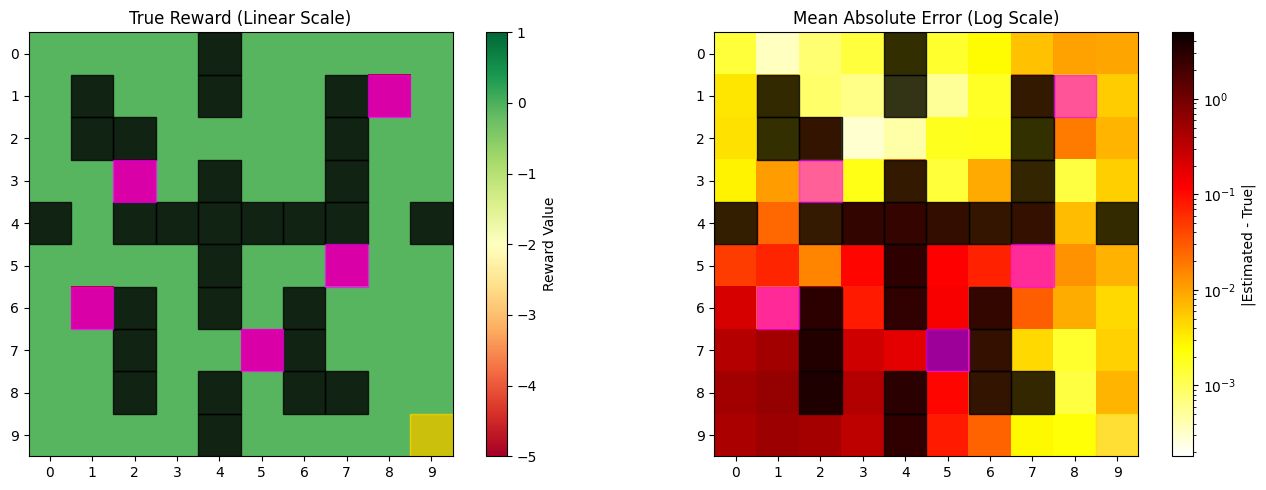

In [53]:
solver_e1 = FOGASSolverVectorized(
    mdp=mdp2,
    csv_path=str(DATASET_PATH),
    device=device,
    seed=seed)
evaluator_e1 = FOGASEvaluator(solver_e1)
evaluator_e1.analyze_reward_approximation(
    walls=walls, 
    pits=pits, 
    goal=goal
)

In [51]:
# Run solver with best alpha and fixed rho, eta
solver_e1.run(alpha=0.001 / 2, eta=0.0002, rho=0.05, tqdm_print=True, T=13000)
evaluator_e1.print_optimal_path(goal_state=99)

FOGAS:   0%|                                                                                                                                                   | 0/13000 [00:00<?, ?it/s]

FOGAS: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13000/13000 [00:07<00:00, 1712.32it/s]


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Goal State: 99
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 1       │ Reward:  -0.100 │ → 12
  Step   3 │ State: 12       │ Action: 3       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 3       │ Reward:  -0.100 │ → 16
  Step   9 │ State: 16       │ Action: 0       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7   

# Data analysis

The coverage ratio $ \|\lambda_{\pi^*}\|_{\Lambda_n^{-1}}^2 $ measures how much of the "feature mass" required by the optimal policy $\pi^*$ is supported by the directions spanned by the dataset. In the context of the FOGAS framework, $\lambda_{\pi^*}$ represents the expected feature vectors generated by the optimal policy. Using the Eigen-Decomposition of the empirical feature covariance matrix $\Lambda_n$, we can visualize this. Let

$$
\Lambda_n = \sum_{j=1}^d \sigma_j u_j u_j^\top,
$$

where $u_j$ are the principal directions of your dataset in the RBF feature space and $\sigma_j$ are the amounts of data (eigenvalues) in those directions. The coverage ratio becomes:

$$
\|\lambda_{\pi^*}\|_{\Lambda_n^{-1}}^2
=
\sum_{j=1}^d
\frac{\langle \lambda_{\pi^*}, u_j \rangle^2}{\sigma_j}.
$$

Alignment-based coverage with RBFs means that for every direction $u_j$ where the optimal policy has a high occupancy projection, the dataset must have a corresponding high eigenvalue $\sigma_j$. This requires that the data samples sufficiently activate the specific RBF kernels that characterize the optimal policy's trajectory.

One major difference is that RBF features allow for *interpolated coverage*, which is a significant advantage over the one-hot tabular setting. In the tabular case, if a specific state-action pair has zero counts ($N(x,a) = 0$), the coverage ratio can blow up, mitigated only by the regularization parameter $\beta$.

With RBFs, if the dataset contains samples $(X_i, A_i)$ that are near an optimal pair $(x,a)$, the RBF activations will overlap due to their radial nature. This means the dataset provides "partial coverage" for nearby states through the feature correlation inherent in the RBF map. This allows the algorithm to learn about regions of the state-space not explicitly present in the data, potentially resulting in a lower (better) coverage ratio and improved sample complexity compared to a tabular model with the same sparse data.


In [43]:
analyzer = DatasetAnalyzer(DATASET_PATH2)

ratio = analyzer.feature_coverage_ratio(
    mdp=mdp,
    use_optimal_policy=True,
    verbose=True,
    return_details=True,
)


Feature Coverage Ratio Details
------------------------------
  Dataset size (n):         8000
  MDP dims (N, A, d):        (100, 4, 132)
  gamma:                    0.9
  beta (ridge):             0
  policy source:            provided

  Occupancy μ_pi summary:
    sum:                    1
    min / max:              0 / 0.1

  Feature occupancy λ_pi summary:
    ||λ||_2:                0.806593
    ||λ||_1:                3.7411
    max |λ_i|:              0.521495

  Empirical covariance Λ_n:
    diag min / mean / max:  2.14839e-05 / 0.0201328 / 0.318875
    eig min / max:          1.80629e-10 / 0.508542
    condition number:       2.8154e+09

  Coverage ratio:           1.8832


Much smaller coverage ratio!!

In [21]:
df_results = pd.read_csv(GRID_PATH)

For each dataset setting—given an exploration level $\epsilon$, an “optimal injection” mixture $\alpha$ (e.g. $\pi_b=(1-\alpha)\pi_\epsilon+\alpha\pi^*$), and a dataset size $n$—these three metrics separate *task success*, *on-data reliability*, and *performance on the truly important (optimal) regions*: 

(1) the **default-start return** $J(\hat\pi;\rho_{\text{start}})=\mathbb{E}_{s_0\sim\rho_{\text{start}}}[V^{\hat\pi}(s_0)]$ tells us whether the learned policy solves the environment from the standard start distribution; 

(2) the **data-weighted regret**(ON DATA QUALITY) $\mathbb{E}_{s\sim d_{\text{data}}}[V^*(s)-V^{\hat\pi}(s)]$ tells us how close we are to optimal **where the dataset actually provides support** (it improves as $n$ grows and as $\epsilon$ increases coverage, but can look good even if it fail in rarely-seen states); 

and (3) the **optimal-occupancy–weighted regret** $\mathbb{E}_{s\sim d_{\pi^*}}[V^*(s)-V^{\hat\pi}(s)]$ tells us how good we are on the states that matter under optimal behavior (good performance in the optimal states and it typically improves when $\alpha$ increases because the dataset aligns better with $d_{\pi^*}$, and when $n$ increases because we reduce estimation/extrapolation error).


In [ ]:
# ── Load Results ──────────────────────────────────────────────────────────────
# For tabular:  grid_search_results_sbatch.csv
# For RBF:      grid_search_results_sbatch_rbf.csv
CSV_NAME = "grid_search_results_sbatch_rbf.csv"   # ← RBF
# The script saves the CSV in the CWD where sbatch runs (FOGAS root)
RESULTS_PATH = Path("/shared/home/mauro.diaz/work/FOGAS") / CSV_NAME
df_results = pd.read_csv(RESULTS_PATH)
print(f"✅ Loaded {len(df_results)} rows from '{RESULTS_PATH}'")
print(f"   Columns: {list(df_results.columns)}")
df_results.head()
# ── Performance Analysis Plots ────────────────────────────────────────────────
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.dpi'] = 100

x_vars = ["Dataset Size", "Epsilon", "Proportions", "Init Mode"]
y_vars = ["Coverage Ratio", "Convergence", "Final Reward", "V Optimal Gap", "Q Optimal Gap"]

# Columns that need x-tick rotation (categorical)
ROTATE_COLS = {"Proportions", "Init Mode"}

print("📊 Generating Performance Analysis Plots...")

for y_var in y_vars:
    if y_var not in df_results.columns:
        print(f"⚠️  Warning: '{y_var}' not found in results — skipping.")
        continue

    fig, axes = plt.subplots(1, len(x_vars), figsize=(22, 5))
    fig.suptitle(f'Impact of Dataset Parameters on  [{y_var}]',
                 fontsize=18, fontweight='bold', y=1.03)

    for i, x_var in enumerate(x_vars):
        ax = axes[i]
        if x_var not in df_results.columns:
            ax.set_visible(False)
            continue

        sns.lineplot(
            data=df_results,
            x=x_var,
            y=y_var,
            marker='o',
            markersize=7,
            linewidth=2,
            err_style="band",
            ax=ax,
        )

        ax.set_title(f'{y_var}\nvs {x_var}', fontsize=13, pad=8)
        ax.set_xlabel(x_var, fontsize=11)
        ax.set_ylabel(y_var if i == 0 else "", fontsize=11)
        ax.grid(True, linestyle="--", alpha=0.5)

        if x_var in ROTATE_COLS:
            ax.tick_params(axis='x', rotation=35)

    plt.tight_layout()
    plt.show()

# Linear Fitted Q-Iteration

Given an offline batch dataset $\mathcal{D}={(x_i,a_i,r_i,x_i')}_{i=1}^n$, this version of (linear) FQI does:

1. **Build targets using current Q estimate**
   $$
   y_i^{(k)} = r_i + \gamma \max_{a'} Q_{\theta_k}(x'_i, a')
   $$

2. **Fit a new Q-function to those targets** by regression on $(x_i,a_i)$
   $$
   \theta_{k+1}^{+}
   = \arg\min_\theta \sum_{i=1}^n \left(y_i^{(k)} - \phi(x_i,a_i)^\top\theta\right)^2 + \lambda|\theta|_2^2
   $$

3. (Optional) **soft update**:
   $$
   \theta_{k+1} = \tau,\theta_k + (1-\tau),\theta_{k+1}^{+}
   $$

LEt's try first with the dataset of FOGAS:

In [57]:
# Initialize FQI Solver
solver_fqi = FQISolver(
    mdp=mdp2,
    csv_path=str(DATASET_PATH),
    device=device,
    seed=seed)
evaluator_fqi = FQIEvaluator(solver_fqi)

In [58]:
pi_fqi = solver_fqi.run(
    K=1000, 
    tau=0.1, 
    verbose=True
)
print("\nFQI Policy:")
evaluator_fqi.print_policy()
evaluator_fqi.compare_final_rewards()
evaluator_fqi.print_optimal_path(max_steps=30)

FQI: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4214.99it/s, theta_norm=inf]



FQI Policy:

========== LEARNED POLICY (FQI) ==========
  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 1.00  π(a=3|s=1) = 0.00  --> best action: 2
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.00  π(a=2|s=2) = 1.00  π(a=3|s=2) = 0.00  --> best action: 2
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 1.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 1
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 0.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 1.00  --> best action: 3
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 1.00  π(a=3|s=6) = 0.00  --> best action: 2
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 1.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 0.00  --> best action: 1
  State 8: π(a=0|s=8) = 0.00  π(a=1|s=8) = 1.00  π(a=2|s=8) = 0.00  π(a=3|s=8) = 0.00  --> best

## RBF FQI

Initialized 81 RBF centers (9x9 grid)
Feature Dimension (d): 324


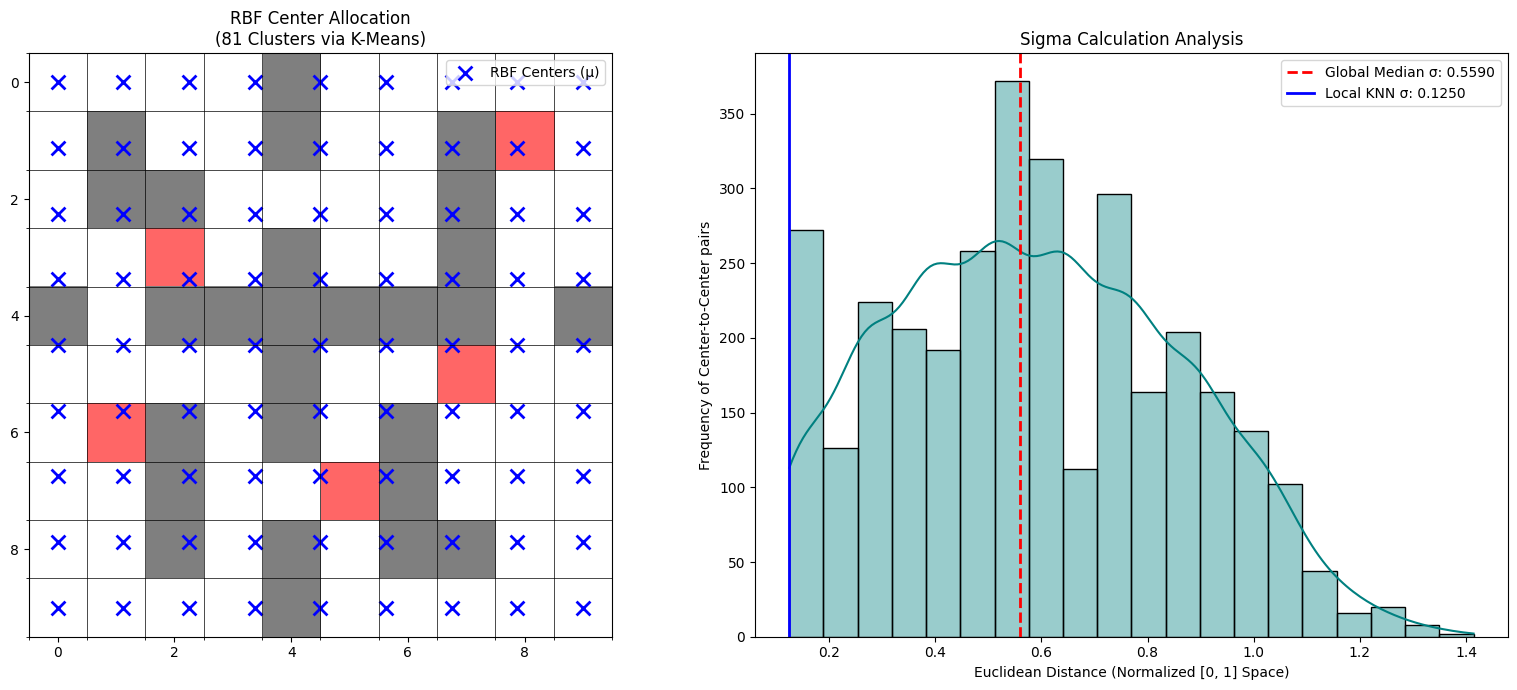

Metric                    | Value     
----------------------------------------
Global Median Sigma       | 0.559017
Local KNN Sigma (k=2)     | 0.125000
Difference (%)            | 77.64%
----------------------------------------
RATIONALE:
1. Global Median: Better for 'Smoothing'—covers the whole range of distances.
2. Local KNN: Better for 'Precision'—ensures centers only overlap with their
   immediate neighbors, preventing blurry feature activations across rooms.


In [37]:
# -----------------------------------------------------------------------
# MDP 3 — Regular Grid
# -----------------------------------------------------------------------
def get_grid_centers3(n_side=10):
    """
    Places centers on a perfect n_side x n_side lattice (normalized coords).
    Total centers = n_side^2.
    """
    centers = []
    for r in range(n_side):
        for c in range(n_side):
            # Map indices to [0.0, 1.0] range
            # We divide by (n_side - 1) to ensure the first is at 0 and last is at 1
            val_r = r / (n_side - 1.0) if n_side > 1 else 0.5
            val_c = c / (n_side - 1.0) if n_side > 1 else 0.5
            centers.append([val_r, val_c])
    return torch.tensor(centers, dtype=torch.float64)

# --- CONFIGURATION ---
# Change this to 5 for 25 centers, 8 for 64 centers, 10 for 100, etc.
RBF_GRID_SIDE = 9 
# ---------------------

# 1. Initialize RBF Centers
centers3   = get_grid_centers3(n_side=RBF_GRID_SIDE)
# Dynamically calculate local sigma for the new configuration
rbf_sigma3 = calculate_local_sigma(centers3, k=2)

print(f"Initialized {len(centers3)} RBF centers ({RBF_GRID_SIDE}x{RBF_GRID_SIDE} grid)")

def phi_state3(x):
    """Pure RBF activation only. No bias (ones), no indicators."""
    coords  = get_norm_coords(x) # Still maps underlying state to [0,1]
    dist_sq = torch.sum((coords - centers3)**2, dim=1)
    rbf     = torch.exp(-dist_sq / (2 * rbf_sigma3**2))
    return rbf

def phi3(x, a):
    """Coupled Feature Map: phi(x, a) = e_a ⊗ rbf_state(x)."""
    s_feat = phi_state3(x)
    e_a    = torch.zeros(A, dtype=torch.float64)
    e_a[int(a)] = 1.0
    return torch.kron(e_a, s_feat)

d3 = int(phi3(states[0], actions[0]).shape[0])
print(f"Feature Dimension (d): {d3}")

# ---------- Create MDP 3 ----------
mdp3 = PolicySolver(
    states=states, actions=actions, phi=phi3,
    reward_fn=reward_fn, gamma=gamma, x0=0, P=P,
)

# --- Run Visualizer ---
# This will now show the spatial distribution for your chosen number of centers
visualize_rbf_analysis(centers3, walls, pits, goal)

DATASET_PATH2 = PROJECT_ROOT / "datasets" / "10grid_rbf_fqi.csv"


In [26]:
walls = [4, 11, 14, 17, 21, 22, 27, 34, 37, 40, 42, 43, 44, 45, 46, 47, 49, 54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94]
pits = [18, 32, 57, 61, 75]
goal = [99]

# Configure the probabilities: 
# 80% of trajectories start in a random "safe" state
# 20% of trajectories start in the fixed initial state (x0)
reset_options = {
    'random': 0.8, 
    'x0': 0.2
}

# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_rbf",
    restricted_states=walls,  # These will never be starting states
    reset_probs=reset_options,
    max_steps=50
)

collector.collect_dataset_terminal_aware(
    n_steps=30000, extra_steps=5, save_path=str(DATASET_PATH2), verbose=True
)

✅ Terminal-aware dataset saved to: /shared/home/mauro.diaz/work/FOGAS/datasets/10grid_rbf_fqi.csv
   Total transitions: 30000


,episode,step,state,action,reward,next_state
0,0,0,3,0,-0.1,3
1,0,1,3,3,-0.1,3
2,0,2,3,2,-0.1,2
3,0,3,2,1,-0.1,12
4,0,4,12,1,-0.1,12
...,...,...,...,...,...,...
29995,950,25,3,0,-0.1,3
29996,950,26,3,3,-0.1,3
29997,950,27,3,1,-0.1,13
29998,950,28,13,2,-0.1,12


In [68]:
analyzer = DatasetAnalyzer(DATASET_PATH2)

analyzer.analyze_state(33)


Analysis for State 33
Total visits to this state: 174
Actions seen: 4, Missing: 0
State mean count: 43.50 (Global mean: 69.44)
Avg diff from global mean: -25.94
------------------------------------------------------------
Per-Action Breakdown:
------------------------------------------------------------
  Action  0: count=  46, diff=  -23.4, z=-0.37 
  Action  1: count=  49, diff=  -20.4, z=-0.32 
  Action  2: count=  40, diff=  -29.4, z=-0.46 
  Action  3: count=  39, diff=  -30.4, z=-0.48 


{'state_stats': {'state': 33,
  'total_visits': 174,
  'n_actions_seen': 4,
  'n_actions_missing': 0,
  'state_mean': 43.5,
  'state_std': 4.153311931459037,
  'min_action_count': 39,
  'max_action_count': 49,
  'global_mean': 69.44444444444444,
  'avg_diff_from_global': -25.944444444444443},
 'action_details':    state  action  count  diff_from_mean  ratio_to_mean   z_score
 0     33       0     46      -23.444444         0.6624 -0.367417
 1     33       1     49      -20.444444         0.7056 -0.320402
 2     33       2     40      -29.444444         0.5760 -0.461448
 3     33       3     39      -30.444444         0.5616 -0.477120}

Initialized 72 RBF centers (KMeans on non-wall states)
Local sigma (k=2): 0.088889
Feature Dimension (d): 288


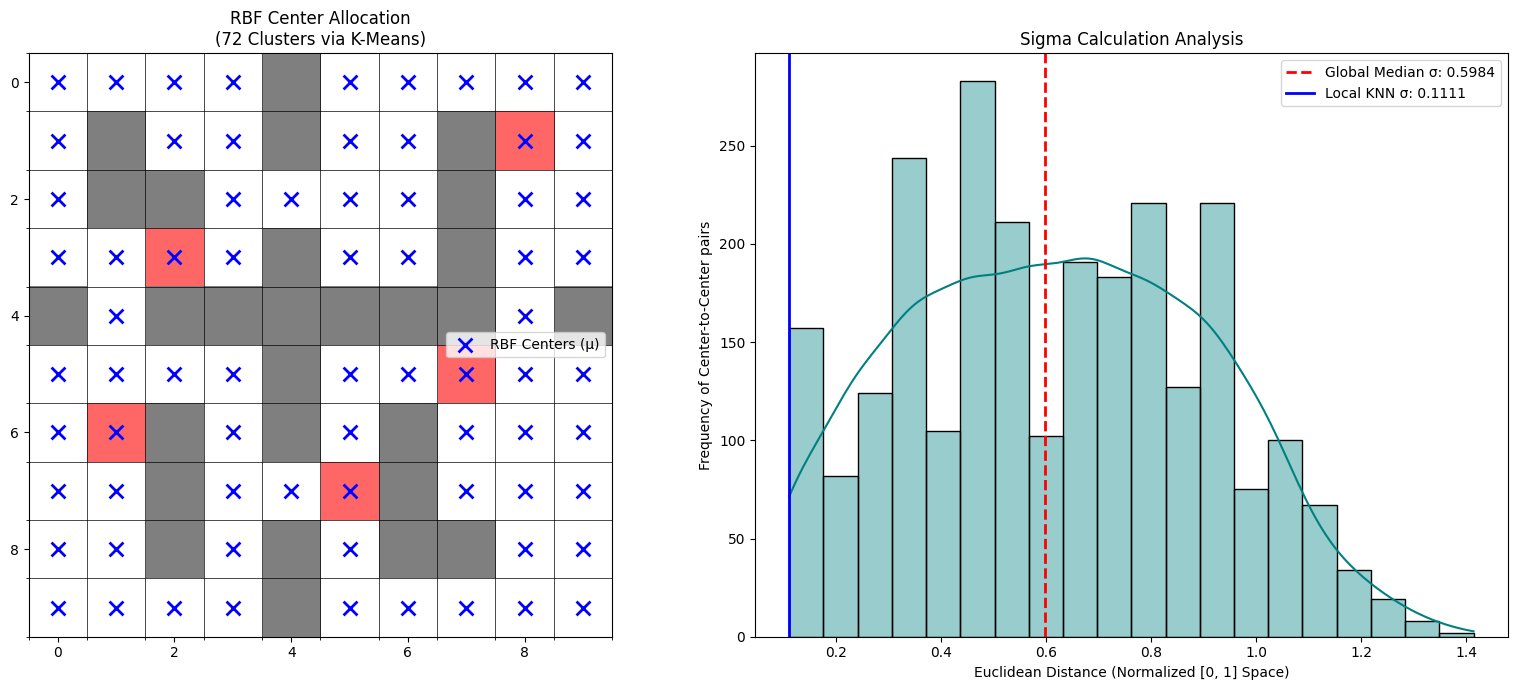

Metric                    | Value     
----------------------------------------
Global Median Sigma       | 0.598352
Local KNN Sigma (k=2)     | 0.111111
Difference (%)            | 81.43%
----------------------------------------
RATIONALE:
1. Global Median: Better for 'Smoothing'—covers the whole range of distances.
2. Local KNN: Better for 'Precision'—ensures centers only overlap with their
   immediate neighbors, preventing blurry feature activations across rooms.


In [79]:
# -----------------------------------------------------------------------
# MDP 3 — KMeans centers, pure RBF (no extra features)
# -----------------------------------------------------------------------

# --- CONFIGURATION ---
RBF_N_CENTERS3 = 72 
# ---------------------

def get_kmeans_centers2(num_centers=25, include_walls=False):
    """K-Means centers on normalized grid coords.
    include_walls=False → cluster only non-wall states (original behaviour)
    include_walls=True  → cluster all 100 states including walls
    """
    valid_coords = []
    for s in range(100):
        if not include_walls and s in walls:
            continue
        r, c = divmod(s, 10)
        valid_coords.append([r / 9.0, c / 9.0])
    kmeans = KMeans(n_clusters=num_centers, n_init=10, random_state=42).fit(valid_coords)
    return torch.tensor(kmeans.cluster_centers_, dtype=torch.float64)

centers3   = get_kmeans_centers2(num_centers=RBF_N_CENTERS3, include_walls = False)
rbf_sigma3 = calculate_local_sigma(centers3, k=2) * 0.8

print(f"Initialized {len(centers3)} RBF centers (KMeans on non-wall states)")
print(f"Local sigma (k=2): {rbf_sigma3:.6f}")

def phi_state3(x):
    """Pure RBF activation only. No bias, no indicators."""
    coords  = get_norm_coords(x)
    dist_sq = torch.sum((coords - centers3)**2, dim=1)
    rbf     = torch.exp(-dist_sq / (2 * rbf_sigma3**2))
    return rbf

def phi3(x, a):
    """Coupled Feature Map: phi(x, a) = e_a ⊗ phi_state3(x)."""
    s_feat = phi_state3(x)
    e_a    = torch.zeros(A, dtype=torch.float64)
    e_a[int(a)] = 1.0
    return torch.kron(e_a, s_feat)

d3 = int(phi3(states[0], actions[0]).shape[0])
print(f"Feature Dimension (d): {d3}")

# ---------- Create MDP 3 ----------
mdp3 = PolicySolver(
    states=states, actions=actions, phi=phi3,
    reward_fn=reward_fn, gamma=gamma, x0=0, P=P,
)

# --- Run Visualizer ---
visualize_rbf_analysis(centers3, walls, pits, goal)

DATASET_PATH2 = PROJECT_ROOT / "datasets" / "10grid_rbf_fqi.csv"


In [80]:
# Initialize FQI Solver
solver_fqi = FQISolver(
    mdp=mdp3,
    csv_path=str(DATASET_PATH2),
    device=device,
    seed=seed,
    ridge=1e-6
)
evaluator_fqi = FQIEvaluator(solver_fqi)
pi_fqi = solver_fqi.run(
    K=5000, 
    tau=0.1, 
    verbose=True
)
print("\nFQI Policy:")
evaluator_fqi.print_policy()
evaluator_fqi.compare_final_rewards()
evaluator_fqi.print_optimal_path(max_steps=24)

FQI: 100%|██████████████████████████████████████████████████████| 5000/5000 [00:07<00:00, 667.90it/s, theta_norm=539.5888]



FQI Policy:

========== LEARNED POLICY (FQI) ==========
  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 0.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 1.00  --> best action: 3
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.00  π(a=2|s=2) = 0.00  π(a=3|s=2) = 1.00  --> best action: 3
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 1.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 1
  State 5: π(a=0|s=5) = 0.00  π(a=1|s=5) = 0.00  π(a=2|s=5) = 0.00  π(a=3|s=5) = 1.00  --> best action: 3
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.00  π(a=1|s=8) = 0.00  π(a=2|s=8) = 0.00  π(a=3|s=8) = 1.00  --> best

In [76]:
# =============================================================================
# GREEDY SEARCH: Minimum RBF Centers for FQI Convergence
# =============================================================================
# Strategy:
#   Start at n_centers = 72 (known working config), go down by 1.
#   For each n_centers, grid-search over (ridge, sigma_multiplier).
#   Convergence = trajectory from x0 reaches state 99 within max_steps.
#
#   If no config converges:
#     → Retry excluding pits from the KMeans pool (state_mode='no_pit')
#     → Retry also excluding goal              (state_mode='no_pit_no_goal')
#     → If still nothing → declare failure and stop outer loop.
# =============================================================================

import itertools
import numpy as np

# ── Hyperparameter grid ──────────────────────────────────────────────────────
RIDGES         = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0]
SIGMA_MULTS    = [0.8, 1.0, 1.2, 1.5, 2.0]
K_ITERS        = 5000
TAU            = 0.1
MAX_PATH_STEPS = 24
GOAL_STATE     = 99
START_CENTERS  = 72     # inclusive upper bound
# ─────────────────────────────────────────────────────────────────────────────


def build_phi3_closure(n_centers, sigma_mult, state_mode='standard'):
    """
    Build (centers, phi_state3_fn, phi3_fn, d) for a given configuration.

    state_mode:
        'standard'      → exclude walls only (normal behaviour)
        'no_pit'        → exclude walls + pits
        'no_pit_no_goal'→ exclude walls + pits + goal
    """
    # 1. Decide which states are eligible for clustering
    excluded = set(walls)
    if state_mode in ('no_pit', 'no_pit_no_goal'):
        excluded |= set(pits)
    if state_mode == 'no_pit_no_goal':
        excluded.add(goal)

    valid_coords = []
    for s in range(100):
        if s not in excluded:
            r, c = divmod(s, 10)
            valid_coords.append([r / 9.0, c / 9.0])

    # Need at least n_centers non-excluded states
    if len(valid_coords) < n_centers:
        return None

    kmeans = KMeans(n_clusters=n_centers, n_init=10, random_state=42).fit(valid_coords)
    _centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float64)

    # 2. Compute base sigma and apply multiplier
    _base_sigma = calculate_local_sigma(_centers, k=2)
    _sigma      = _base_sigma * sigma_mult

    # 3. Closure (captures _centers and _sigma by value)
    def _phi_state(x, centers=_centers, sigma=_sigma):
        coords  = get_norm_coords(x)
        dist_sq = torch.sum((coords - centers) ** 2, dim=1)
        return torch.exp(-dist_sq / (2 * sigma ** 2))

    def _phi(x, a, centers=_centers, sigma=_sigma):
        s_feat      = _phi_state(x, centers=centers, sigma=sigma)
        e_a         = torch.zeros(A, dtype=torch.float64)
        e_a[int(a)] = 1.0
        return torch.kron(e_a, s_feat)

    d = int(_phi(int(states[0]), int(actions[0])).shape[0])
    return _centers, _sigma, _phi_state, _phi, d


def reaches_goal(solver_fqi, max_steps=MAX_PATH_STEPS, goal=GOAL_STATE):
    """Return True iff the simulated trajectory visits the goal state."""
    evaluator = FQIEvaluator(solver_fqi)
    traj = evaluator.simulate_trajectory(max_steps=max_steps)
    visited = {s for s, a, r, sn in traj} | {sn for s, a, r, sn in traj}
    return goal in visited


def try_config(n_centers, ridge, sigma_mult, state_mode):
    """
    Build MDP + run FQI for one (n_centers, ridge, sigma_mult, state_mode).
    Returns True if it converges (reaches goal), False otherwise.
    Catches all exceptions.
    """
    try:
        result = build_phi3_closure(n_centers, sigma_mult, state_mode)
        if result is None:
            return False

        _centers, _sigma, _phi_state_fn, _phi_fn, d_local = result

        # Build a fresh MDP (PolicySolver) with the new phi
        _mdp = PolicySolver(
            states=states, actions=actions, phi=_phi_fn,
            reward_fn=reward_fn, gamma=gamma, x0=0, P=P,
        )

        _solver = FQISolver(
            mdp=_mdp,
            csv_path=str(DATASET_PATH2),
            device=device,
            seed=seed,
            ridge=ridge,
        )
        _solver.run(K=K_ITERS, tau=TAU, verbose=False)

        return reaches_goal(_solver)

    except Exception as e:
        # Uncomment for debugging:
        # print(f"      [EXC] n={n_centers} ridge={ridge} sm={sigma_mult} mode={state_mode}: {e}")
        return False


# =============================================================================
# MAIN GREEDY SEARCH LOOP
# =============================================================================
print("=" * 70)
print("  GREEDY SEARCH — minimum RBF centers for FQI convergence")
print("=" * 70)
print(f"  Ridge candidates  : {RIDGES}")
print(f"  Sigma multipliers : {SIGMA_MULTS}")
print(f"  K={K_ITERS},  tau={TAU},  max_path_steps={MAX_PATH_STEPS}")
print(f"  Starting from n_centers = {START_CENTERS}, decreasing by 1")
print("=" * 70)

STATE_MODES   = ['standard', 'no_pit', 'no_pit_no_goal']
MODE_LABELS   = {
    'standard':       'exclude walls only',
    'no_pit':         'exclude walls + pits',
    'no_pit_no_goal': 'exclude walls + pits + goal',
}

search_log  = []   # list of dicts with full result per trial
min_centers = None # will hold the answer

for n_centers in range(START_CENTERS, 0, -1):
    print(f"\n{'─'*70}")
    print(f"  Testing n_centers = {n_centers}")
    print(f"{'─'*70}")

    found_for_n = False

    for mode in STATE_MODES:
        print(f"\n  [Mode] {MODE_LABELS[mode]}")
        found_for_mode = False

        for ridge, sm in itertools.product(RIDGES, SIGMA_MULTS):
            converged = try_config(n_centers, ridge, sm, mode)
            status    = "✅ CONVERGED" if converged else "   failed   "
            print(f"    ridge={ridge:.0e}  sigma_mult={sm:.2f}  → {status}")

            search_log.append({
                "n_centers"   : n_centers,
                "state_mode"  : mode,
                "ridge"       : ridge,
                "sigma_mult"  : sm,
                "converged"   : converged,
            })

            if converged:
                found_for_mode = True
                found_for_n    = True
                break   # ← stop inner loop immediately on first convergence

        if found_for_mode:
            print(f"\n  ✅ n_centers={n_centers} converges in mode '{mode}' "
                  f"(ridge={ridge:.0e}, sigma_mult={sm:.2f})")
            break   # ← stop mode loop, no need to try stricter exclusions

        else:
            print(f"\n  ✗  No convergence in mode '{mode}' — trying stricter exclusion...")

    if not found_for_n:
        print(f"\n  ✗  n_centers={n_centers} FAILED in ALL modes.")
        print(f"  → Minimum working n_centers = {n_centers + 1}")
        min_centers = n_centers + 1
        break

    # If we get here, n_centers worked → record it and try n_centers-1
    min_centers = n_centers
    print(f"\n  ✅ n_centers={n_centers} works — continuing search for fewer centers...")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("  GREEDY SEARCH COMPLETE")
print("=" * 70)

if min_centers is not None:
    print(f"\n  🏆  Minimum n_centers where FQI converges = {min_centers}\n")
else:
    print(f"\n  ⚠️  Search exhausted without finding minimum (all tried converge).\n")

# Best configs (converged=True) sorted by n_centers ascending, then ridge
import pandas as pd
df_search = pd.DataFrame(search_log)
print("Full search log:")
display(df_search)

converged_df = df_search[df_search["converged"]].sort_values(
    ["n_centers", "ridge", "sigma_mult"]
)
print("\nConverging configurations:")
display(converged_df)

# ── Save results to CSV ───────────────────────────────────────────────────────
SEARCH_LOG_PATH   = PROJECT_ROOT / "datasets" / "fqi_center_greedy_search.csv"
CONVERGED_LOG_PATH = PROJECT_ROOT / "datasets" / "fqi_center_greedy_search_converged.csv"
df_search.to_csv(str(SEARCH_LOG_PATH), index=False)
converged_df.to_csv(str(CONVERGED_LOG_PATH), index=False)
print(f"\n✅ Full log saved      → {SEARCH_LOG_PATH}")
print(f"✅ Converged log saved → {CONVERGED_LOG_PATH}")


  GREEDY SEARCH — minimum RBF centers for FQI convergence
  Ridge candidates  : [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]
  Sigma multipliers : [0.8, 1.0, 1.2, 1.5, 2.0]
  K=5000,  tau=0.1,  max_path_steps=24
  Starting from n_centers = 72, decreasing by 1

──────────────────────────────────────────────────────────────────────
  Testing n_centers = 72
──────────────────────────────────────────────────────────────────────

  [Mode] exclude walls only
    ridge=1e-06  sigma_mult=0.80  → ✅ CONVERGED

  ✅ n_centers=72 converges in mode 'standard' (ridge=1e-06, sigma_mult=0.80)

  ✅ n_centers=72 works — continuing search for fewer centers...

──────────────────────────────────────────────────────────────────────
  Testing n_centers = 71
──────────────────────────────────────────────────────────────────────

  [Mode] exclude walls only
    ridge=1e-06  sigma_mult=0.80  →    failed   
    ridge=1e-06  sigma_mult=1.00  →    failed   
    ridge=1e-06  sigma_mult=1.20  →    failed   
    rid

,n_centers,state_mode,ridge,sigma_mult,converged
0,72,standard,0.000001,0.8,True
1,71,standard,0.000001,0.8,False
2,71,standard,0.000001,1.0,False
3,71,standard,0.000001,1.2,False
4,71,standard,0.000001,1.5,False
...,...,...,...,...,...
101,71,no_pit_no_goal,1.000000,0.8,False
102,71,no_pit_no_goal,1.000000,1.0,False
103,71,no_pit_no_goal,1.000000,1.2,False
104,71,no_pit_no_goal,1.000000,1.5,False



Converging configurations:


,n_centers,state_mode,ridge,sigma_mult,converged
0,72,standard,0.000001,0.8,True



✅ Full log saved      → /shared/home/mauro.diaz/work/FOGAS/datasets/fqi_center_greedy_search.csv
✅ Converged log saved → /shared/home/mauro.diaz/work/FOGAS/datasets/fqi_center_greedy_search_converged.csv


### GRID-SEARCH FQI

In [18]:
DATASET_PATH_FQI = PROJECT_ROOT / "datasets" / 'fqi_grid_search_results.csv'

In [ ]:
# Fixed environment parameters
walls = [4, 11, 14, 17, 21, 22, 27, 34, 37, 40, 42, 43, 44, 45, 46, 47, 49, 54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94]
pits = [18, 32, 57, 61, 75]
goal = [99]

# Fixed FQI solver parameters
FQI_PARAMS = {
    'K': 5000,
    'tau': 0.1,
    'ridge': 1e-2,
    'verbose': False
}

# Grid search parameters
reset_configs = {
    "80/20": {'random': 0.8, 'x0': 0.2},
    "60/40": {'random': 0.6, 'x0': 0.4},
    "50/50": {'random': 0.5, 'x0': 0.5},
    "100/0": {'random': 1.0, 'x0': 0.0},
    "0/100": {'random': 0.0, 'x0': 1.0},
}

extra_steps_values = [0, 1, 3, 5]
dataset_sizes = [10000, 15000, 20000, 25000, 30000]

beta_val = 1e-2

# Setup
temp_dir = "temp_fqi_grid_search"
os.makedirs(temp_dir, exist_ok=True)

results = []
total_iters = len(reset_configs) * len(extra_steps_values) * len(dataset_sizes)

print(f"🚀 Starting FQI Grid Search ({total_iters} scenarios)...")
print(f"   Varying: reset probabilities, extra_steps, dataset size")
print(f"   Computing: Task Success, Coverage Ratio\n")

# Grid search loop
with tqdm(total=total_iters, desc="FQI Grid Searching") as pbar:
    for reset_label, reset_probs in reset_configs.items():
        for extra_steps in extra_steps_values:
            for n_steps in dataset_sizes:
                fname = f"fqi_{reset_label}_extra{extra_steps}_n{n_steps}.csv"
                save_path = os.path.join(temp_dir, fname)
                
                # A. Collect Dataset
                try:
                    collector = EnvDataCollector(
                        mdp=mdp,
                        env_name="10grid_wall",
                        restricted_states=walls,
                        terminal_states=list(pits) + (goal if isinstance(goal, list) else [goal]),
                        reset_probs=reset_probs,
                        max_steps=50,
                        seed=seed
                    )
                    
                    collector.collect_dataset_terminal_aware(
                        n_steps=n_steps,
                        extra_steps=extra_steps,
                        save_path=save_path,
                        verbose=False
                    )
                except Exception as e:
                    print(f"\n⚠️  Dataset collection failed: {e}")
                    pbar.update(1)
                    continue
                
                # B. Analyze Feature Coverage
                try:
                    analyzer = DatasetAnalyzer(save_path)
                    coverage_ratio = analyzer.feature_coverage_ratio(
                        mdp=mdp, beta=beta_val, use_optimal_policy=True, verbose=False
                    )
                except:
                    coverage_ratio = np.nan
                
                # C. Train FQI and Evaluate
                try:
                    # Initialize FQI Solver
                    solver_fqi = FQISolver(
                        mdp=mdp,
                        csv_path=save_path,
                        device=device,
                        seed=seed,
                        ridge=FQI_PARAMS['ridge']
                    )
                    
                    # Run FQI
                    pi_fqi = solver_fqi.run(
                        K=FQI_PARAMS['K'],
                        tau=FQI_PARAMS['tau'],
                        verbose=FQI_PARAMS['verbose']
                    )
                    
                    # Evaluate
                    evaluator_fqi = FQIEvaluator(solver_fqi)
                    task_success = evaluator_fqi.final_reward()
                    
                    # Check convergence (if solver tracks this)
                    converged = evaluator_fqi.converged()
                    
                except Exception as e:
                    print(f"\n⚠️  FQI training/evaluation failed: {e}")
                    task_success = np.nan
                    converged = False
                
                # Store results
                results.append({
                    "Reset Config": reset_label,
                    "Extra Steps": extra_steps,
                    "Dataset Size": n_steps,
                    "Coverage Ratio": coverage_ratio,
                    "Log Coverage": np.log10(coverage_ratio) if coverage_ratio > 0 else np.nan,
                    "Task Success": task_success,
                    "Converged": converged,
                })
                
                # Cleanup
                if os.path.exists(save_path):
                    os.remove(save_path)
                pbar.update(1)

# Cleanup temp directory
if os.path.exists(temp_dir):
    try:
        os.rmdir(temp_dir)
    except:
        pass

# Create results dataframe
df_fqi_results = pd.DataFrame(results)

print("\n✅ FQI Grid Search Complete!")
print(f"   Total scenarios: {len(df_fqi_results)}")
print(f"   Successful runs: {df_fqi_results['Task Success'].notna().sum()}")
print(f"   Failed runs: {df_fqi_results['Task Success'].isna().sum()}")
if 'Converged' in df_fqi_results.columns:
    print(f"   Converged runs: {df_fqi_results['Converged'].sum()}\n")

# Display results
display(df_fqi_results.head(10))

# Save results
df_fqi_results.to_csv(str(DATASET_PATH_FQI), index=False)
print("✅ Results saved to ", DATASET_PATH_FQI)

# Summary statistics
print("\n" + "="*70)
print("  FQI GRID SEARCH SUMMARY")
print("="*70 + "\n")

print("Coverage Ratio Statistics:")
valid_coverage = df_fqi_results['Coverage Ratio'].dropna()
if len(valid_coverage) > 0:
    print(f"  Mean:   {valid_coverage.mean():.6f}")
    print(f"  Median: {valid_coverage.median():.6f}")
    print(f"  Min:    {valid_coverage.min():.6f}")
    print(f"  Max:    {valid_coverage.max():.6f}\n")

print("Task Success Statistics:")
valid_data = df_fqi_results['Task Success'].dropna()
if len(valid_data) > 0:
    print(f"  Mean:   {valid_data.mean():.6f}")
    print(f"  Median: {valid_data.median():.6f}")
    print(f"  Std:    {valid_data.std():.6f}")
    print(f"  Min:    {valid_data.min():.6f}")
    print(f"  Max:    {valid_data.max():.6f}\n")

# Best configurations
print("Top 5 Configurations by Task Success:")
top_configs = df_fqi_results.nlargest(5, 'Task Success')[
    ['Reset Config', 'Extra Steps', 'Dataset Size', 'Coverage Ratio', 'Task Success', 'Converged']
]
print(top_configs.to_string(index=False))
print("\n" + "="*70)


If already done, download the results from the grid search job.

In [19]:
df_fqi_results = pd.read_csv(DATASET_PATH_FQI)

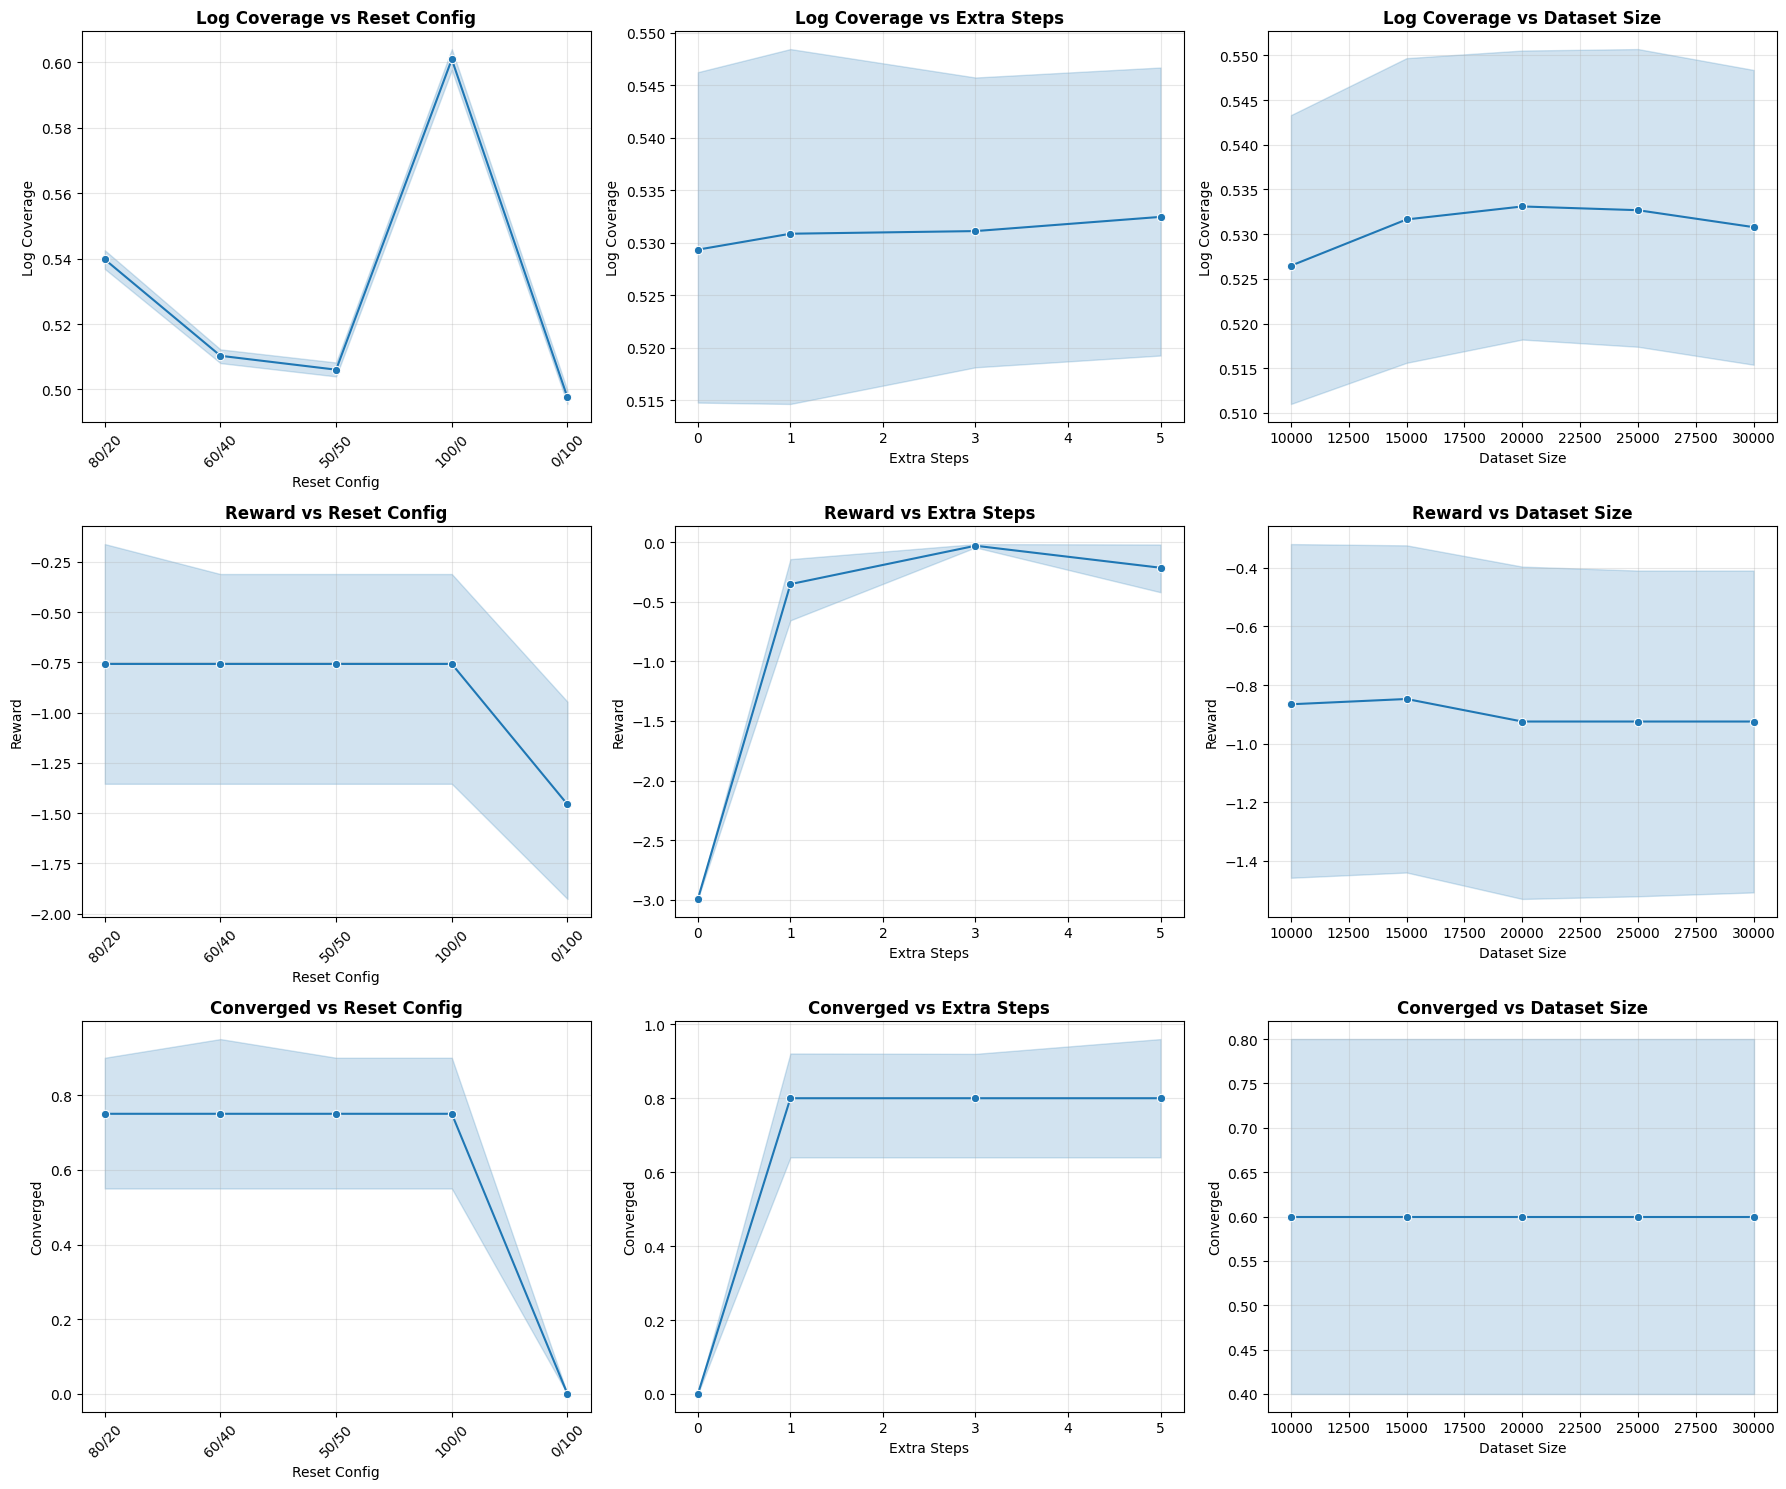

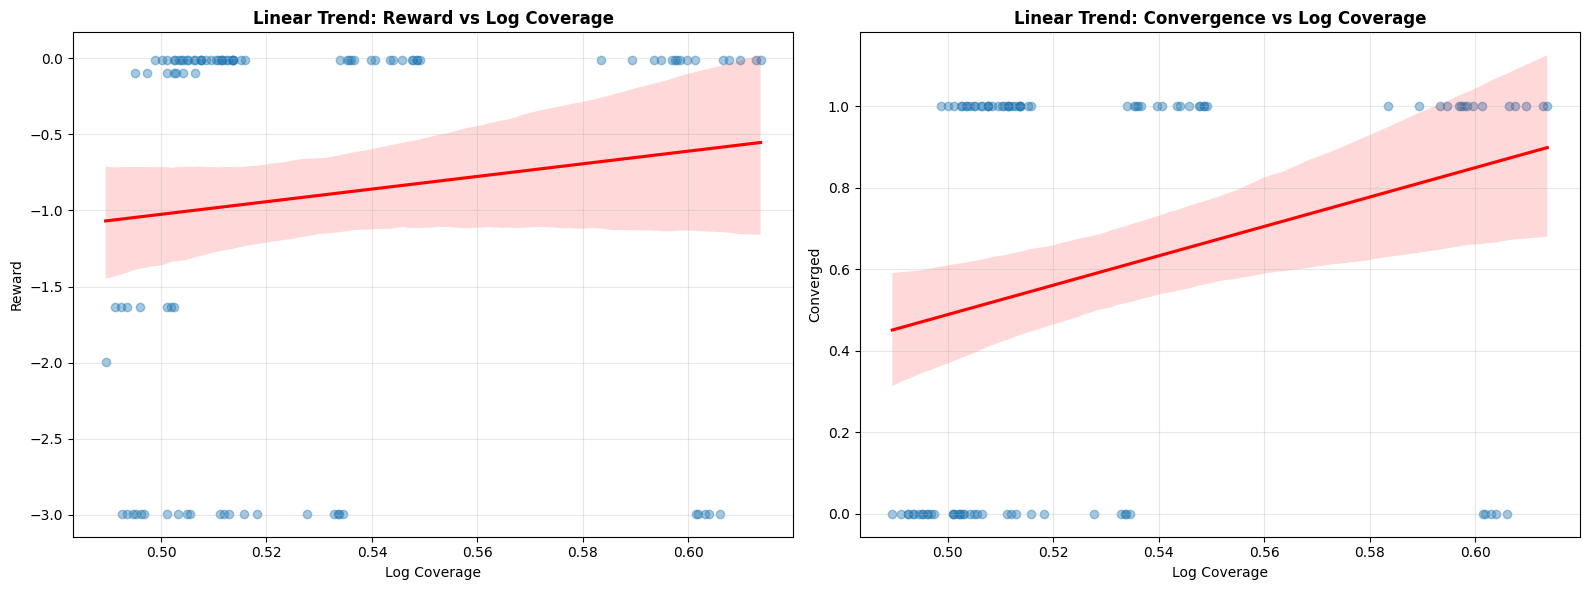

In [17]:
# 1. Prepare the dataframe: rename column and ensure metrics are numeric
df_plot = df_fqi_results.copy()
if 'Task Success' in df_plot.columns:
    df_plot = df_plot.rename(columns={'Task Success': 'Reward'})
# 2. Define our axes
variables = ['Reset Config', 'Extra Steps', 'Dataset Size']
metrics = ['Log Coverage', 'Reward', 'Converged']
# 3. Create the 3x3 Grid (Linear Trends vs Independent Variables)
fig, axes = plt.subplots(len(metrics), len(variables), figsize=(18, 15))
for i, metric in enumerate(metrics):
    for j, var in enumerate(variables):
        ax = axes[i, j]
        # Using lineplot for the categorical/discrete summary
        sns.lineplot(data=df_plot, x=var, y=metric, marker='o', ax=ax)
        
        ax.set_title(f'{metric} vs {var}', fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        if var == 'Reset Config':
            ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
# 4. RELATIONSHIP ANALYSIS (Linear Trend)
# Replacing the scatter plot with the regplots you preferred
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot A: Linear Trend of Reward vs Log Coverage
sns.regplot(data=df_plot, x='Log Coverage', y='Reward', ax=axes[0], 
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
axes[0].set_title('Linear Trend: Reward vs Log Coverage', fontweight='bold')
axes[0].grid(True, alpha=0.3)
# Plot B: Linear Trend of Convergence vs Log Coverage
sns.regplot(data=df_plot, x='Log Coverage', y='Converged', ax=axes[1], 
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
axes[1].set_title('Linear Trend: Convergence vs Log Coverage', fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()